# Project 1, Part 4, Holiday Analytics

University of California, Berkeley
Master of Information and Data Science (MIDS) program
w205 - Fundamentals of Data Engineering

Student: Landon Morin

Year: 2022

Semester: Spring

Section: 9


# Included Modules and Packages

Code cell containing your includes for modules and packages

In [40]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
from calendar import day_name
import warnings


import psycopg2

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [41]:
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [42]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

In [43]:
cursor = connection.cursor()
warnings.filterwarnings('ignore')

## How do holidays affect the sales, considering both the actual holiday, and the days before and after the holiday? 

## Create an executive summary explaining how holidays have affected sales. 

## You must support your summary with data, in the form of output of queries, data visualization, etc. There is a 1 query minimum.

# Executive Summary

## Introduction

Holiday season sales are strong, with only President's Day, Labor Day, Memorial Day, and MLK day underperforming the average no holiday week (see **Fig 2**). For other holidays, increasing holiday sales are mostly driven by an uptick in purchasing pre and post holiday. On large holidays like Christmas and Thanksgiving, AGM is closed, but the increase in sales before and after these holidays result in a higher net revenue than a normal week (see **Fig 2**). Veteran's Day, Father's Day, Easter, Mother's Day, and Independence Day all outperform Christmas and New Years on a seven day time frame. 

All holidays experience either flat sales or lower sales on the day of the holiday (see **Fig 1 & 3**). Perhaps this is due to changes in consumer preferences, and time-constraints. Presumably, most consumers will be spending time with family on holidays, putting together complex feasts, and staying home. All of these factors result in lower sales for our pre-prepared gourmet, healthy meals. 


Based on our data analysis, we recommend special holiday themed meals to be put on sale 7 days prior to the holiday. This will drive more excitement and sales leading up to the holiday, and will also allow for the last minute family member to purchase a special, easy, meal for the holiday. 






# Part 1: Merging Sales Table and Holidays Table

In [44]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select sa.sale_date,
       h.holiday_date,
       to_char(date_trunc('day', sa.sale_date), 'Day') as day_of_week,
       to_char(date_trunc('day', h.holiday_date), 'Day') as day_of_week_hol,
       sum(sa.total_amount) as total_sales,
       h.description as holiday 
from sales as sa
    full join holidays as h
        on h.holiday_date = sa.sale_date
group by sa.sale_date, h.holiday_date
order by sa.sale_date, extract(dow from sa.sale_date)

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

#cleaning up the dataframe in pandas.
df['sale_date'] = df['sale_date'].combine_first(df['holiday_date'])
df = df.drop('holiday_date', axis = 1)
df['day_of_week'] = df['day_of_week'].combine_first(df['day_of_week_hol'])
df = df.drop('day_of_week_hol', axis = 1)
df = df.sort_values(by = 'sale_date')
df = df.reset_index()
df = df.drop('index', axis = 1)
df['sale_date'] = pd.to_datetime(df['sale_date'])
df['total_sales'] = df['total_sales'].fillna(0)
df['day_of_week'] = df['day_of_week'].str.strip()
df

,sale_date,day_of_week,total_sales,holiday
0,2020-01-01,Wednesday,133776,New Year's Day
1,2020-01-02,Thursday,261120,None
2,2020-01-03,Friday,263076,None
3,2020-01-04,Saturday,400368,None
4,2020-01-05,Sunday,394992,None
...,...,...,...,...
361,2020-12-27,Sunday,396096,None
362,2020-12-28,Monday,264852,None
363,2020-12-29,Tuesday,130440,None
364,2020-12-30,Wednesday,263424,None


**The dataframe above provides an overview of sales by date, and inlcudes a holiday name, if there is a holiday on that date. Note, Christmas and Thanksgiving did not have sales dates. We merged the dates for Christmas and Thanksgiving with the sale date column and filled the missing sales data with zero. This will provide us with continuous data for better data visualization.**

In [45]:
rollback_before_flag = True
rollback_after_flag = True


query = """

select case 
           when h.description is null then extract('week' from sa.sale_date)
           else extract('week' from h.holiday_date)
           end week,
       sum(sa.total_amount) as total_sales,
       h.description as holiday,
       to_char(date_trunc('day', h.holiday_date), 'Day') as holiday_day
from sales as sa
    full join holidays as h
        on h.holiday_date = sa.sale_date
group by week, h.description, h.holiday_date
order by week


"""

df1 = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
#Cleaning the dataframe
df1.loc[:,'total_sales'] = df1.loc[:,'total_sales'].ffill()

df1 = df1.sort_values('holiday').drop_duplicates(subset = 'week', keep = 'first')
df1 = df1.sort_values('week')
df1['holiday'] = df1['holiday'].fillna('No Hol')
df1.tail(10)

,week,total_sales,holiday,holiday_day
52,44,1982484,No Hol,None
53,45,1996332,No Hol,None
54,46,271920,Veterans Days,Wednesday
56,47,1983384,No Hol,None
57,48,1983384,Thanksgiving,Thursday
59,49,1994232,No Hol,None
60,50,1977900,No Hol,None
61,51,1981560,No Hol,None
62,52,1981560,Christmas,Friday
64,53,924816,No Hol,None


**The dataframe above provides a weekly view of sales and holidays. Each holiday corresponds with a week of the year, and each holiday shows the weekday that it rests on. As we can see, there are quite a few holidays which rest at or near Monday, which is the beginning of the week for SQL. It is important to take this into consideration when calculating total sales for the holiday's week. We must take into account the day on which the holiday sits before determining in which week the holiday rests.**

# Part 2: Exploratory Data Analysis

In [46]:
#Exploring day of week average sales when there is a holiday.
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hol = df[df['holiday'].isna() == False]
dow_sales = hol.groupby('day_of_week').mean()
dow_sales = dow_sales.rename(columns={'total_sales':'average_sales'}).reset_index()
dow_sales['day_of_week'] = pd.Categorical(dow_sales['day_of_week'], categories=cats, ordered=True)
dow_sales = dow_sales.sort_values('day_of_week')
dow_sales

,day_of_week,average_sales
1,Monday,132153.0
5,Wednesday,202848.0
4,Thursday,0.0
0,Friday,0.0
2,Saturday,134952.0
3,Sunday,135260.0


In [59]:
#Exploring day of week average sales when we remove holidays.
no_hol = df[df['holiday'].isna()]
dow_sales_no_hol = no_hol.groupby('day_of_week').mean()
dow_sales_no_hol = dow_sales_no_hol.rename(columns={'total_sales':'average_sales'}).reset_index()
dow_sales_no_hol['day_of_week'] = pd.Categorical(dow_sales_no_hol['day_of_week'], categories=cats, ordered=True)
dow_sales_no_hol = dow_sales_no_hol.sort_values('day_of_week')
dow_sales_no_hol

,day_of_week,average_sales
1,Monday,265395.272727
5,Tuesday,132577.142857
6,Wednesday,265523.454545
4,Thursday,266387.4
0,Friday,266290.363636
2,Saturday,397819.090909
3,Sunday,398571.428571


In [48]:
dowm = pd.merge(dow_sales, dow_sales_no_hol, on = 'day_of_week', how = 'left')

In [49]:
dowm = dowm.rename(columns = {'average_sales_x':'average_sales_hol', 'average_sales_y':'average_sales_no_hol'})

In [50]:
dowm

,day_of_week,average_sales_hol,average_sales_no_hol
0,Monday,132153.0,263314.75
1,Wednesday,202848.0,265624.705882
2,Thursday,0.0,266050.846154
3,Friday,0.0,252522.117647
4,Saturday,134952.0,378166.823529
5,Sunday,135260.0,371087.510204


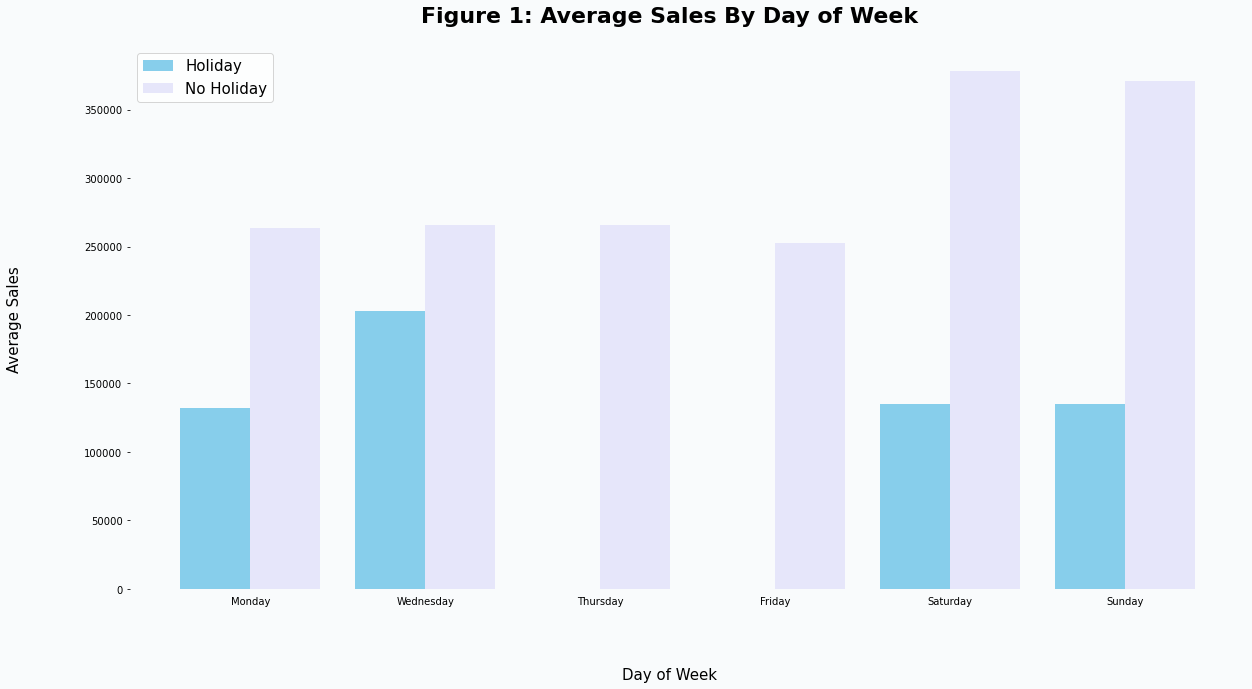

In [51]:
fig, ax = plt.subplots(figsize=(20,10))
x = dowm['day_of_week'].values
y1 = dowm['average_sales_hol'].values
y2 = dowm['average_sales_no_hol'].values

_x = np.arange(len(x))

ax.bar(_x - 0.2, y1, 0.4, color = 'skyblue')
ax.bar(_x + 0.2, y2, 0.4, color = 'lavender')
plt.xticks(_x, x) # set labels manually

ax.tick_params(bottom=False)

ax.set_frame_on(False)

ax.legend(('Holiday','No Holiday'), fontsize = 15, loc='best')


fig.text(0.5, 0, 'Day of Week', ha='center', fontsize = 15)
fig.text(.04, .5, 'Average Sales', va='center', rotation='vertical', fontsize = 15)
fig.text(
    x=0.5, 
    y=0.92,
    s="Figure 1: Average Sales By Day of Week",
    ha="center",
    va="center",
    ma="center",
    fontsize=22,
    fontweight="bold"
)

# Sets background color
fig.set_facecolor("#f9fbfc")

**The above chart demonstrates sales on holidays tend to underperform regular days. There were no sales on Thursday and Friday holidays because those days were Thanksgiving and Christmas respectively. Even without these two outliers, we can see that we are underperforming on all holiday dates. As we will see, the week leading up to a holiday tells a completely different story**

In [52]:
#Creating a dataframe to analyze average sales for weeks that don't contain a holiday and for weeks that do. 
week_sales = df1.groupby('holiday').mean('total_sales')
week_sales.reset_index()
week_sales = week_sales.drop('week', axis = 1)
week_sales['total_sales'] = week_sales['total_sales'].astype(int)
week_sales = week_sales.reset_index()
week_sales

,holiday,total_sales
0,Christmas,1981560
1,Easter,136164
2,Father's Day,135120
3,Independence Day,134952
4,Labor Day,130020
5,MLK Day,130740
6,Memorial Day,132624
7,Mother's Day,134496
8,New Year's Day,133776
9,No Hol,1899063


**The dataframe above measures the average revenue in weeks that don't contain holidays (No Hol) and in weeks that do. This dataframe is useful for calculating sales for the average no-holiday week. However, because some holidays start at the beginning of the week, we will need to calculate total sales for a holiday's week by calculating sales in the 7 days prior.**

In [53]:
#Creating a loop that counts 7 days before (or 7 days after for New Years) a holiday.

idx = df[df['holiday'].isna() == False].index
idx

holiday_pad1 = pd.DataFrame()
for i in idx: 
    if i > 7:
        basedate = df.loc[i]['sale_date']
        temp = df.loc[i-7:i]
        temp['time_since'] = temp['sale_date'].apply(lambda x: (x.to_pydatetime() - basedate).days)
        temp['7 Day Prior Total Sales'] = temp['total_sales'].sum()
        holiday_pad1 = holiday_pad1.append(temp)
        del temp
    else: 
        basedate = df.loc[i]['sale_date']
        temp = df.loc[i: i+8]
        temp['time_since'] = temp['sale_date'].apply(lambda x: (x.to_pydatetime() - basedate).days)
        temp['7 Day Prior Total Sales'] = temp['total_sales'].mean()
        holiday_pad1 = holiday_pad1.append(temp)
        del temp
        
holiday_pad1 = holiday_pad1.groupby('holiday').mean('total_holiday_sales')
holiday_pad1 = holiday_pad1.reset_index()
holiday_pad1 = holiday_pad1.drop(['total_sales', 'time_since'], axis = 1)
holiday_pad1 = holiday_pad1.append(week_sales.loc[week_sales['holiday'] == 'No Hol'])
holiday_pad1['7 Day Prior Total Sales'].fillna(holiday_pad1['total_sales'], inplace = True)
holiday_pad1.drop('total_sales', axis = 1, inplace = True)
holiday_pad1 = holiday_pad1.rename(columns = {'7 Day Prior Total Sales':'week_total_sales'})

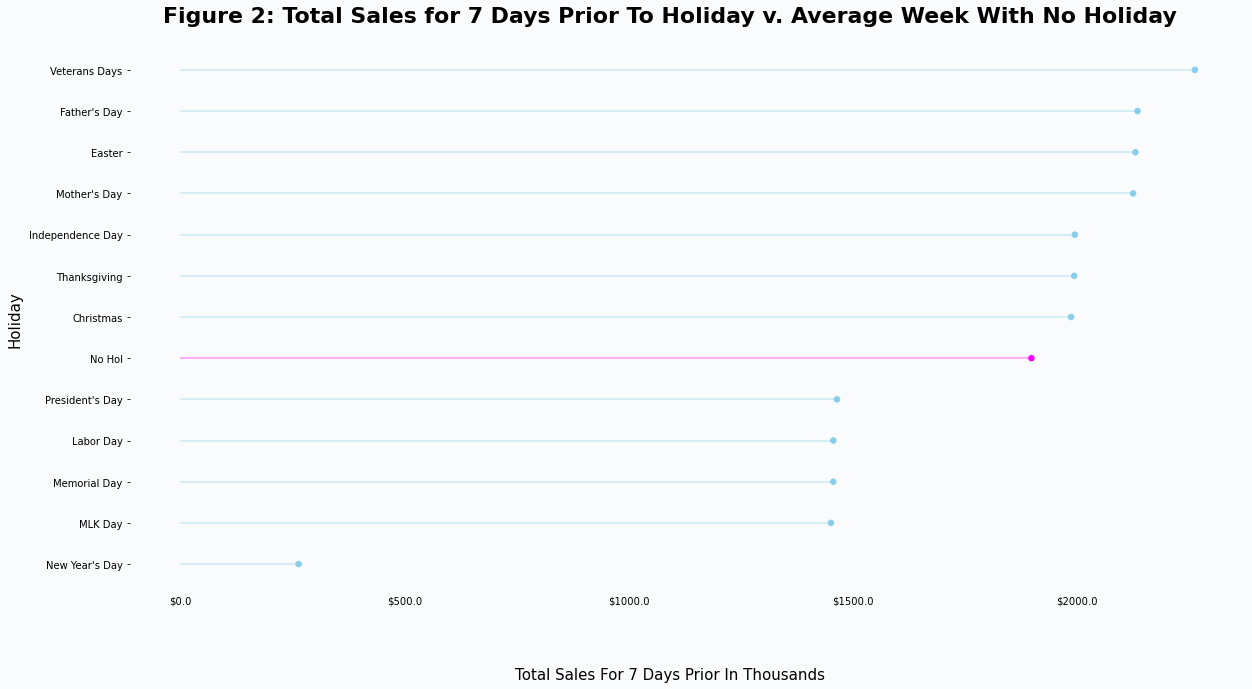

In [60]:
#Function to change format of large numbers.
def thousands_formatter(x, pos):
    return f'${x / 1000}'

fig, ax = plt.subplots(figsize=(20,10))
#Reorder dataframe based on sales
ordered_week = holiday_pad1.sort_values(by='week_total_sales')
my_range=range(1,len(ordered_week.index)+1)
 
# identify no holiday clearly in magenta
my_color=np.where(ordered_week['holiday']=='No Hol', 'magenta', 'skyblue')
my_size=np.where(ordered_week['holiday']=='B', 70, 30)
 
#The horizontal plot is made using the hline() function
ax.hlines(y=my_range, xmin=0, xmax=ordered_week['week_total_sales'], color=my_color, alpha=0.4)
ax.scatter(ordered_week['week_total_sales'], my_range, color=my_color, s=my_size, alpha=1)
 
# Add title and axis names
plt.yticks(my_range, ordered_week['holiday'])
ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))

ax.tick_params(bottom=False)
ax.set_frame_on(False)

#clean it up and make it look pretty
fig.text(0.5, 0, 'Total Sales For 7 Days Prior In Thousands', ha='center', fontsize = 15)
fig.text(.04, .5, 'Holiday', va='center', rotation='vertical', fontsize = 15)
fig.text(
    x=0.5, 
    y=0.92,
    s="Figure 2: Total Sales for 7 Days Prior To Holiday v. Average Week With No Holiday",
    ha="center",
    va="center",
    ma="center",
    fontsize=22,
    fontweight="bold"
)

fig.set_facecolor("#f9fbfc")


**The figure above shows that our stores outperform on over half of the holidays. We only underperform Presidents's Day, Labor Day, Memorial Day, and MLK day. It is important to recognize that we don't have any data of sales in the lead up to New Year's. Therefore, we can only measure performance after the holiday.**

In [55]:
#creating lead/lag for holidays
idx = df[df['holiday'].isna() == False].index
idx

holiday_pad = pd.DataFrame()
temp = pd.DataFrame()
for i in idx: 
    if i > 10:
        basedate = df.loc[i]['sale_date']
        temp = df.iloc[i-10: i+11]
        temp['holiday'] = df.iloc[i]['holiday']
        temp['time_since'] = temp['sale_date'].apply(lambda x: (x.to_pydatetime() - basedate).days)
        temp['period_avg_sales'] = temp['total_sales'].mean()
        holiday_pad = holiday_pad.append(temp)
        del temp
    else: 
        basedate = df.loc[i]['sale_date']
        temp = df.iloc[i: i+11]
        temp['holiday'] = df.iloc[i]['holiday']
        temp['time_since'] = temp['sale_date'].apply(lambda x: (x.to_pydatetime() - basedate).days)
        temp['period_avg_sales'] = temp['total_sales'].mean()
        holiday_pad = holiday_pad.append(temp)
        del temp


In [56]:
#Preparing for graphing. Defining a formatting function.
holidays = holiday_pad['holiday'].unique()

hol1 = holidays[0]

def thousands_formatter(x, pos):
    return f'${x / 1000}'

In [57]:
#Function to add labels.
#Add_label and plot_holiday are two functions adapted from python-graph-gallery.com. 
#They are reworked and customized to align with the goals of this project and to make it my own. 
def add_label(x, y, z, fontsize, color, ax):
    PAD = -160000
    ax.annotate(
        f"${round(float(z)/1000, 2)}", 
        xy=(x + .7, y + PAD), 
        ha="center", 
        va="bottom",
        fontsize=fontsize,
        fontweight='bold',
        zorder=12,
        color=color
    )

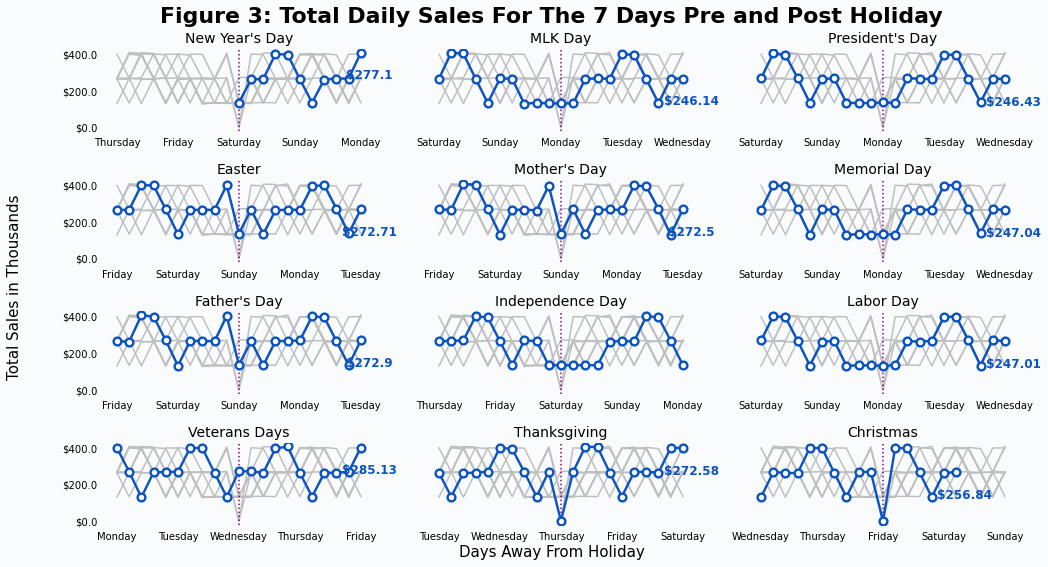

In [58]:
def plot_holiday(holiday, data, ax):
    
    for hol_inner in holidays:
    #Filter data to keep rows of the holiday.
        d = data[data["holiday"] == hol_inner] 
        x = list(d["time_since"].values.astype(float))
        y = list(d["total_sales"].values.astype(float))
        z = list(d['period_avg_sales'].values)

        if hol_inner == holiday:
            ax.plot(x, y, color="#0b53c1", lw=2.4, zorder=10)
            ax.scatter(x, y, fc="w", ec="#0b53c1", s=60, lw=2.4, zorder=12)
            ax.set_xticklabels(d['day_of_week'].values)
            add_label(x[-1], y[-1], z[1], 12, '#0b53c1', ax)
        else:
            ax.plot(x, y, color="#BFBFBF", lw=1.5)
        
    ax.yaxis.set_ticks_position('none') 
    ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

    
    ax.tick_params(bottom=False)
    ax.set_frame_on(False)

    ax.set_title(holiday, fontsize=14, fontweight=500)
    ax.axvline(0, color='purple', ls="dotted")
    return ax


fig, axes = plt.subplots(4, 3, sharex=False, sharey=True, figsize=(14, 7.5))
for idx, (ax, holiday) in enumerate(zip(axes.ravel(), holidays)):
    plot_holiday(holiday, holiday_pad, ax)


#Making it pretty with annotations, labels, and layout. 
fig.subplots_adjust(wspace=0.1, left=0.025, right=0.975, bottom=0.11, top=0.82)
fig.tight_layout(pad = 1.5)
# Adds title.
fig.text(
    x=0.5, 
    y=1,
    s="Figure 3: Total Daily Sales For The 7 Days Pre and Post Holiday",
    ha="center",
    va="center",
    ma="center",
    fontsize=22,
    fontweight="bold"
)

fig.text(0.5, 0, 'Days Away From Holiday', ha='center', fontsize = 15)
fig.text(-.04, .5, 'Total Sales in Thousands', va='center', rotation='vertical', fontsize = 15)
fig.set_facecolor("#f9fbfc")

**Figure 3 shows sales in the 10 days leading up to the holiday and in the 10 days after. Our store experiences mixed sales outcomes around holidays. Labor Day, Presidents Day, and Memorial Day all experience flat sales leading into the holiday and on the holiday. Furthermore, there is not unusual spend after these holidays. Fathers Day, Easter, and Mother's Day experience a sharp increase in spend the day before the holiday, but a drop in spend on the holiday. Thanksgiving, Veterans Day, Christmas, and Independence Day all experience increased sales a few days before the holiday, but flat or low sales on the holiday (zero on New Years and Christmas). Veterans Day, Thanksgiving, and Christmas also experienced strong spending in the few days after the holiday.**
